# Group Project Milestone 2: Data Exploration & Initial PreProcessing

In this assignment you will need to:

1. Create a GitHub ID
2. Create a GitHub Repository (Public or Private it is up to you. In the end it will have to be Public) and add your group members as collaborators
3. Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
4. Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
5. How will you preprocess your data? You should explain this in your README.md file and link your Jupyter notebook to it. All code and  Jupyter notebooks have be uploaded to your repo.
6. You must also include in your Jupyter Notebook, a link for data download and environment setup requirements: 


!wget !unzip like functions as well as !pip install functions for non standard libraries not available in colab are required to be in the top section of your jupyter lab notebook. Or having the data on GitHub (you will need the academic license for GitHub to do this, larger datasets will require a link to external storage).

## GitHub ID

https://github.com/SmoothData-BigBrain

## Dataset link

https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022

## Setup for spark and data

Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.

### Import libraries

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import util


from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, isnan, when, count, isnull, sum

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Creat Spark session

In [10]:
spark = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.sparkContext.setLogLevel("ERROR")

### Read in data files

> **Note: Update the home_dir and download_path variables before running this cell block**

In [13]:
# home_dir = os.path.expanduser('~')
# path_for_Nam = 'C:/GitGroupProject/GroupProject' # comment this later
# download_path = os.path.join(path_for_Nam,'/data/') # comment this later

# download_path = os.path.join('/workspaces/GroupProject/data/') # Uncomment this later

home_dir = os.path.expanduser('~')
mihir_download_path = os.path.join(home_dir, 'Desktop/GroupProject/data/')
file_id = '1tch7xbFIgBtXKXa16E4QCpVKedUExfO3'  # My File ID for airlines.zip on GDrive 
util.check_and_fetch_data(file_id, mihir_download_path)

No CSV files found in C:\Users\ahyo\Desktop/GroupProject/data/. Fetching data...


Downloading...
From (original): https://drive.google.com/uc?id=1tch7xbFIgBtXKXa16E4QCpVKedUExfO3
From (redirected): https://drive.google.com/uc?id=1tch7xbFIgBtXKXa16E4QCpVKedUExfO3&confirm=t&uuid=3b10c9c9-7c18-45bb-8cce-2727f9628fa1
To: C:\Users\ahyo\Desktop\GroupProject\data\airlines.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.68G/1.68G [00:26<00:00, 63.5MB/s]


Extracting data...
File extracted to: C:\Users\ahyo\Desktop/GroupProject/data/


In [15]:
# folder_path = '~/Desktop/GroupProject/data/archive/raw'
# path_for_Nam = 'C:/GitGroupProject/GroupProject'
# home_dir = os.path.expanduser('~')
# download_path = os.path.join(home_dir, 'Desktop/GroupProject/data/')

# download_path = os.path.join(path_for_Nam, '/data/')
# Nam_local = 'C:/lecture-notebooks/GroupProject/data/archive/raw' # comment this later

# csv_files = glob.glob(f"{Nam_local}/*.csv") # comment this later




### *****************
# Do we want to keep this spark.read.csv or just use parquet files from the start? 
# This would avoid running this, then saving to parquet, and reading parquet files into df again
### *****************
csv_files = glob.glob(f"{mihir_download_path}archive/raw/*.csv") #Uncomment this later
df = spark.read.csv(csv_files,
                       sep = ',',
                       inferSchema = True,
                       header = True)

df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- DOT_ID_Originally_Scheduled_Code_Share_Airline: integer (nullable = true)
 |-- IATA_Code_Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- Flight_Num_Originally_Scheduled_Code_Share_Airline: integer (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_A

In [5]:
# write out combined single csv file - why? 
# df.coalesce(1).write.csv("combined_file_csv", header=True) # Uncomment this later
df.write.mode("overwrite").parquet("combined_files")
df = spark.read.parquet("combined_files")

In [17]:
col_des = spark.read.csv('flights_column_des.csv', sep = ',', inferSchema = True, header = True)

## Explore Dataset

### Get dataset shape

In [19]:
# get df shape
num_entries = df.count()
num_cols = len(df.columns)
print(f"Shape of the DataFrame: ({num_entries}, {num_cols})")

Shape of the DataFrame: (29193782, 120)


### Explore null values

#### Computing non-null counts as percentages

In [23]:
non_null_counts = df.select([count(col(c)).alias(c) for c in df.columns]).collect()[0].asDict()

# Calculate non-null percentages
non_null_percentages = {
    col_name: (count_val / num_entries) * 100
    for col_name, count_val in non_null_counts.items()
}

sorted_columns = sorted(non_null_percentages.items(), key=lambda x: x[1], reverse=True)

for col_name, pct in sorted_columns:
    print(f"{col_name}: {pct:.2f}% non-null")

Year: 100.00% non-null
Quarter: 100.00% non-null
Month: 100.00% non-null
DayofMonth: 100.00% non-null
DayOfWeek: 100.00% non-null
FlightDate: 100.00% non-null
Marketing_Airline_Network: 100.00% non-null
Operated_or_Branded_Code_Share_Partners: 100.00% non-null
DOT_ID_Marketing_Airline: 100.00% non-null
IATA_Code_Marketing_Airline: 100.00% non-null
Flight_Number_Marketing_Airline: 100.00% non-null
Operating_Airline : 100.00% non-null
DOT_ID_Operating_Airline: 100.00% non-null
IATA_Code_Operating_Airline: 100.00% non-null
Flight_Number_Operating_Airline: 100.00% non-null
OriginAirportID: 100.00% non-null
OriginAirportSeqID: 100.00% non-null
OriginCityMarketID: 100.00% non-null
Origin: 100.00% non-null
OriginCityName: 100.00% non-null
OriginState: 100.00% non-null
OriginStateFips: 100.00% non-null
OriginStateName: 100.00% non-null
OriginWac: 100.00% non-null
DestAirportID: 100.00% non-null
DestAirportSeqID: 100.00% non-null
DestCityMarketID: 100.00% non-null
Dest: 100.00% non-null
DestCit

#### Subset dataset
removing columns with <90% null values

In [26]:
columns_above_90 = [col_name for col_name, pct in non_null_percentages.items() if pct >= 90]
filtered_df = df.select(columns_above_90)
filtered_df.select(filtered_df.columns[:8]).show(5)

+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|FlightDate|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|
+----+-------+-----+----------+---------+----------+-------------------------+---------------------------------------+
|2018|      1|    1|        23|        2|2018-01-23|                       DL|                           DL_CODESHARE|
|2018|      1|    1|        24|        3|2018-01-24|                       DL|                           DL_CODESHARE|
|2018|      1|    1|        25|        4|2018-01-25|                       DL|                           DL_CODESHARE|
|2018|      1|    1|        26|        5|2018-01-26|                       DL|                           DL_CODESHARE|
|2018|      1|    1|        27|        6|2018-01-27|                       DL|                           DL_CODESHARE|
+----+-------+-----+----------+---------+-------

In [28]:
# Strip the extra spaces from col names 
for c in filtered_df.columns:
    filtered_df = filtered_df.withColumnRenamed(c, c.strip())

In [30]:
# get filtered df shape
filtered_num_rows = filtered_df.count()
filtered_num_cols = len(filtered_df.columns)
print(f"Shape of the Filtered DataFrame removing cols w/ <90% non-null values: ({filtered_num_rows}, {filtered_num_cols})")

Shape of the Filtered DataFrame removing cols w/ <90% non-null values: (29193782, 62)


In [32]:
filtered_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_Airline: string (nullable = true)
 |-- Tail_Number: string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- OriginCityMarketID: integer (nullable = true)
 |-- Origin: string (null

In [14]:
# delete the master df since we won't need it anymore at all
del df

In [15]:
# save filtered df to not have to redo code later
#filtered_df.coalesce(1).write.mode("overwrite").option("header", True).csv("filtered_df_temp")

# # read in already filtered_df saved previously
# filtered_df = spark.read.csv('part-00000-b248588c-b561-414a-ba2c-bc77825e455a-c000.csv', sep = ',', inferSchema = True, header = True)

#### Discussion on null values
Dataset consists of columns with >90% non-null values and then it drops down to 0-17% non-null. Dataset to be used for further exploration will only include columns with >90% non-null values for more robust analysis

### Remaining Column Descriptions

In [36]:
# get all cols in filtered_df
filtered_cols = filtered_df.columns 

# remove any white space
filtered_cols = [str(c).strip() for c in filtered_cols]

# subset column description dataframe for only columns in filtered dataset
filtered_col_des = col_des.filter(col('column').isin(filtered_cols))

In [38]:
# check df was filtered correctly, length & row count should match
f_col_len = filtered_col_des.count()
f_col_len

62

In [40]:
# View all column descriptions in filtered dataframe
# Full data col description is in "../data/README.md"
filtered_col_des.show(n=f_col_len, truncate=False)

+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column                                 |Description                                                                                                                                                                                                                                           |
+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Year                                   |Year                                                                                        

## Dataset Statistics & Distributions

In [43]:
# get data type for each column
for name, dtype in filtered_df.dtypes:
    print(f"{name}: {dtype}")

Year: int
Quarter: int
Month: int
DayofMonth: int
DayOfWeek: int
FlightDate: date
Marketing_Airline_Network: string
Operated_or_Branded_Code_Share_Partners: string
DOT_ID_Marketing_Airline: int
IATA_Code_Marketing_Airline: string
Flight_Number_Marketing_Airline: int
Operating_Airline: string
DOT_ID_Operating_Airline: int
IATA_Code_Operating_Airline: string
Tail_Number: string
Flight_Number_Operating_Airline: int
OriginAirportID: int
OriginAirportSeqID: int
OriginCityMarketID: int
Origin: string
OriginCityName: string
OriginState: string
OriginStateFips: int
OriginStateName: string
OriginWac: int
DestAirportID: int
DestAirportSeqID: int
DestCityMarketID: int
Dest: string
DestCityName: string
DestState: string
DestStateFips: int
DestStateName: string
DestWac: int
CRSDepTime: int
DepTime: int
DepDelay: double
DepDelayMinutes: double
DepDel15: double
DepartureDelayGroups: int
DepTimeBlk: string
TaxiOut: double
WheelsOff: int
WheelsOn: int
TaxiIn: double
CRSArrTime: int
ArrTime: int
ArrDela

In [45]:
non_string_cols = [col_name for col_name, dtype in filtered_df.dtypes if dtype != 'string']

In [47]:
# subset column description dataframe for only non-string
non_string_col_des = filtered_col_des.filter(col('column').isin(non_string_cols))
non_string_col_des.show(n=non_string_col_des.count(), truncate=False)

+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column                         |Description                                                                                                                                                                                                                                           |
+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Year                           |Year                                                                                                                        

### Discussion on skewed data distributions

When taking a look at the columns with the most amount of skew in the data distribution, columns that are ID inidicators or Flight numbers do not make sense to further investigations of data distributions. Although these are numerical values, they represent categorical variables as opposed to continuous. 

Columns with 'ID','Number', 'Origin', 'Dest' in the column name will be removed from statistical analysis to remove these categorical variables 

In [50]:
cont_col_des = non_string_col_des.filter(
    ~non_string_col_des['column'].rlike('Dest|Origin|ID|Number|FlightDate')
)
cont_col_des.show(n=cont_col_des.count(), truncate=False)

+--------------------+----------------------------------------------------------------------------------------------------------+
|Column              |Description                                                                                               |
+--------------------+----------------------------------------------------------------------------------------------------------+
|Year                |Year                                                                                                      |
|Quarter             |Quarter (1-4)                                                                                             |
|Month               |Month                                                                                                     |
|DayofMonth          |Day of Month                                                                                              |
|DayOfWeek           |Day of Week                                                         

In [52]:
# get statistics for all continuous variables
cont_cols = [row['column'] for row in cont_col_des.select('column').collect()]

describe_df = filtered_df.select(cont_cols).describe()

# compute Q1, Median, Q3 for each column
stats = {
    "25%": {},
    "50%": {},
    "75%": {}
}

for col_name in cont_cols:
    q1, median, q3 = filtered_df.approxQuantile(col_name, [0.25, 0.5, 0.75], 0.01)
    stats["25%"][col_name] = str(q1)
    stats["50%"][col_name] = str(median)
    stats["75%"][col_name] = str(q3)

# convert new rows to df rows
new_rows = [Row(summary=stat_name, **cols) for stat_name, cols in stats.items()]
quartile_df = spark.createDataFrame(new_rows)

# append the new rows to describe_df
full_summary_df = describe_df.unionByName(quartile_df)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "C:\Users\ahyo\anaconda3\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ahyo\anaconda3\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ahyo\anaconda3\Lib\socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# append the new rows to describe_df
full_summary_df = describe_df.unionByName(quartile_df)

In [ ]:
# convert and save as parquet
# full_summary_df.to_parquet("full_summary_df", index=False)
full_summary_df.write.mode("overwrite").parquet("full_summary_df")

In [ ]:
full_summary_df = spark.read.parquet("full_summary_df")

In [ ]:
full_summary_df.select(full_summary_df.columns[:6]).show(truncate=False)

In [ ]:
# view df columns
full_summary_df.select(full_summary_df.columns[11:17]).show(truncate=False)

### Explore skewed data

mean > median, data is right-skewed (longer tail on the right)
median < mean, data is left-skewed (longer tail on the left)

This code is to find top 20 features with largest skews. These features will then be plotted in histograms

The purpose of doing this is to understand if there are any outliers in the dataset that may be worth removing from the dataset prior to applying ML methods

### Explore data distributions

In [ ]:
# get mean and median rows as dicts
mean_row = full_summary_df.filter(col("summary") == "mean").collect()[0].asDict()
median_row = full_summary_df.filter(col("summary") == "50%").collect()[0].asDict()

# skip the 'summary' key
cols = [col for col in mean_row.keys() if col != "summary"]

# build rows of (column, absolute_diff, skew direction)
result_rows = []
for c in cols: # for each col
    mean_val = float(mean_row[c]) # get mean
    median_val = float(median_row[c]) # get median
    diff = __builtins__.abs(mean_val - median_val) # get abs difference
    skew = "right" if mean_val > median_val else "left" if mean_val < median_val else "none" # get skew direction
    result_rows.append(Row(column=c, absolute_diff=diff, skew=skew)) # aggregate

# create df
diff_df = spark.createDataFrame(result_rows)

# get top 20
top_skewed = diff_df.orderBy(col("absolute_diff").desc()).limit(20)

top_skewed.show(truncate=False)


In [ ]:
# get all cols in filtered_df
skewed_cols = [row['column'] for row in top_skewed.select('column').collect()]

# remove any white space
skewed_cols = [str(c).strip() for c in skewed_cols]

# subset column description dataframe for only columns in filtered dataset
skewed_col_des = col_des.filter(col('column').isin(skewed_cols))

In [ ]:
skewed_col_des.show(n=skewed_col_des.count(), truncate=False)

In [ ]:
# list of columns from 'top_skewed'
columns_to_plot = [row['column'] for row in top_skewed.collect()]

# filter the columns that exist in filtered_df
valid_columns = [col for col in columns_to_plot if col in filtered_df.columns]

# plot histograms for each column
n_cols = 4  # 4 histograms per row
n_rows = (len(valid_columns) + n_cols - 1) // n_cols  # calculate num rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))

# flatten axes for easier indexing
axes = axes.flatten()

# loop through cols and plot
for i, column in enumerate(valid_columns):
    hist = filtered_df.select(column).rdd.flatMap(lambda x: x).histogram(20)  # 20 bins

    bin_edges, bin_counts = hist

    # plot the histogram using the bin edges and counts
    axes[i].bar(bin_edges[:-1], bin_counts, width=(bin_edges[1] - bin_edges[0]), edgecolor='black')

    # set axes & title
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# turn off any unused subplots
for i in range(len(valid_columns), len(axes)):
    axes[i].axis('off')

# need to update to add labels for axis 
plt.tight_layout()
plt.show()

### Discussion

The distance column, majority of flights in this dataset have a distance <1000 miles. With a few outliers ranging from 3000-5000 miles. 

Wheels On & Wheels Off time and CRSDepTime & DepTime columns have a few outliers at 0:00-4:00am, majority of times are listed between 5:00 & 23:59

The majority of TaxiOut and TaxiIn times are around 0 (or <50minutes). However, there are outliers sitting at ~1300 & 300 minutes respectively. 

## Questions to analyze data with

### Which Origin Cities had the most delayed flights?

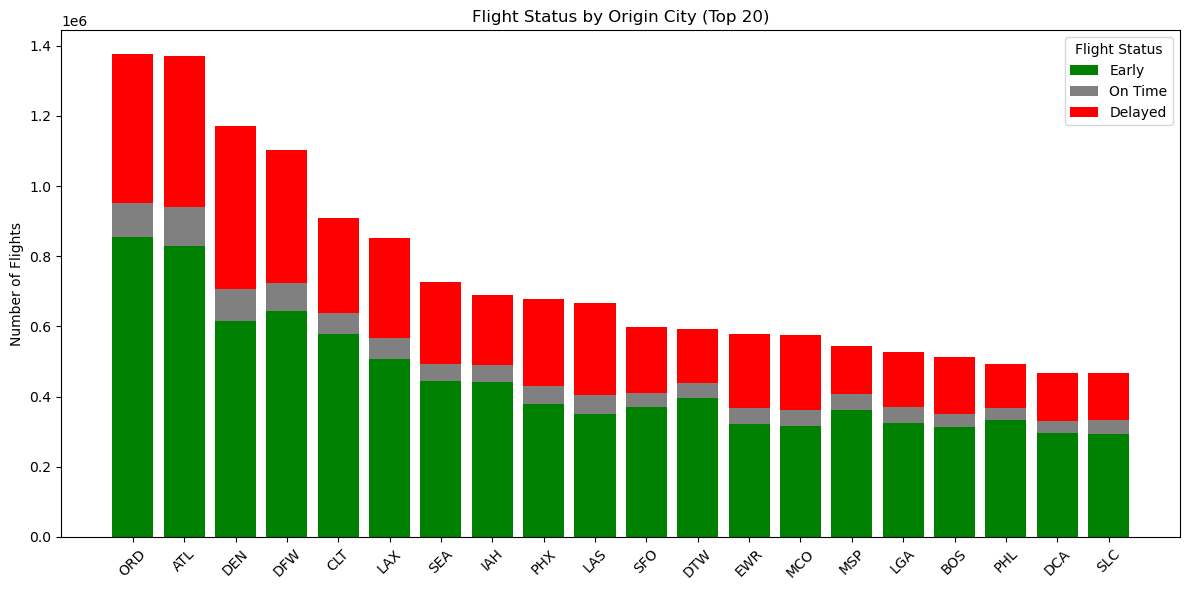

In [56]:
count_delay = filtered_df.select(["Origin", "DepDelay"]).groupBy("Origin")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("TotalCount").desc())
pandas_delay = count_delay.toPandas()# Assuming pdf has these columns: OriginCity, DelayedFlights, EarlyFlights, OnTimeFlights

pdf = pandas_delay.copy()
pdf["OnTimeCount"] = pdf["TotalCount"] - pdf["DelayCount"] - pdf["EarlyCount"]
top_20 = pdf.head(20)

# Bar positions
cities = top_20["Origin"]
x = np.arange(len(cities))

# Heights
early = top_20["EarlyCount"]
on_time = top_20["OnTimeCount"]
delayed = top_20["DelayCount"]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x, early, label="Early", color="green")
plt.bar(x, on_time, bottom=early, label="On Time", color="gray")
plt.bar(x, delayed, bottom=early + on_time, label="Delayed", color="red")

# Labels and formatting
plt.xticks(x, cities, rotation=45)
plt.ylabel("Number of Flights")
plt.title("Flight Status by Origin City (Top 20)")
plt.legend(title="Flight Status")
plt.tight_layout()
plt.show()

#### Discussion


### Which years had the most delayed flights?

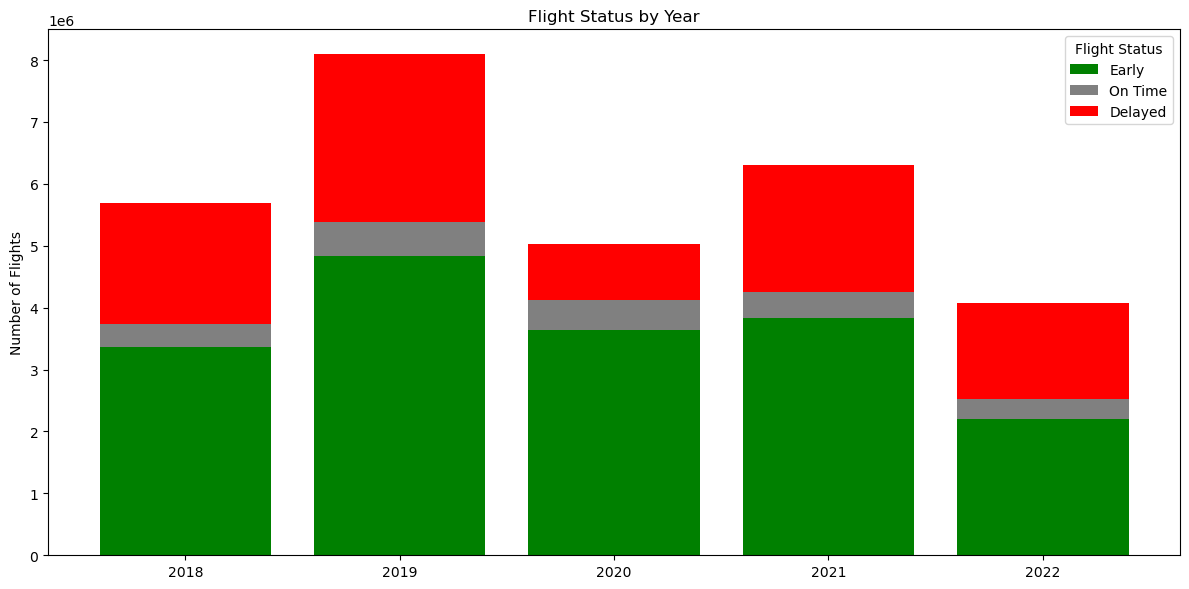

In [58]:
year_delay = filtered_df.select(["Year", "DepDelay"]).groupBy("Year")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("Year"))
pandas_year_delay = year_delay.toPandas()

pydf = pandas_year_delay.copy()
pydf["OnTimeCount"] = pydf["TotalCount"] - pydf["DelayCount"] - pydf["EarlyCount"]
year_counts = pydf

# Bar positions
years = year_counts["Year"]
x = np.arange(len(years))

# Heights
early = year_counts["EarlyCount"]
on_time = year_counts["OnTimeCount"]
delayed = year_counts["DelayCount"]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x, early, label="Early", color="green")
plt.bar(x, on_time, bottom=early, label="On Time", color="gray")
plt.bar(x, delayed, bottom=early + on_time, label="Delayed", color="red")

# Labels and formatting
plt.xticks(x, years)
plt.ylabel("Number of Flights")
plt.title("Flight Status by Year")
plt.legend(title="Flight Status")
plt.tight_layout()
plt.show()

#### Discussion


### Which months had the most delayed flights?

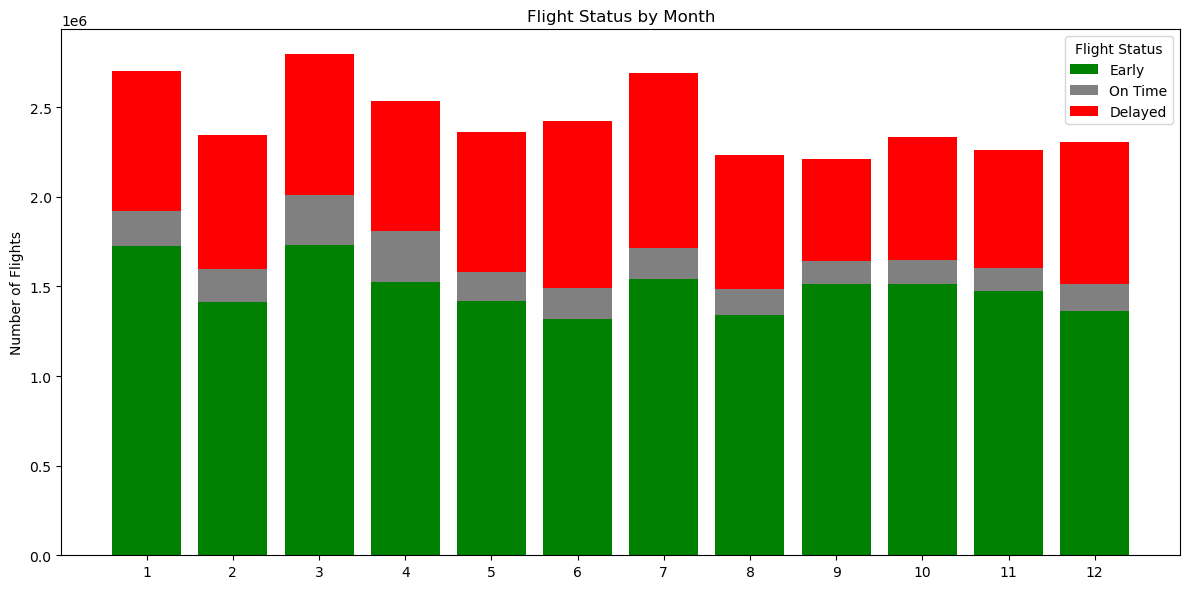

In [62]:
month_delay = filtered_df.select(["Month", "DepDelay"]).groupBy("Month")\
        .agg(count(F.when(col("DepDelay") > 0, 1)).alias("DelayCount"), 
             count(F.when(col("DepDelay") < 0, 1)).alias("EarlyCount"),
            count("*").alias("TotalCount")).orderBy(col("Month"))
pandas_month_delay = month_delay.toPandas()

pmdf = pandas_month_delay.copy()
pmdf["OnTimeCount"] = pmdf["TotalCount"] - pmdf["DelayCount"] - pmdf["EarlyCount"]
month_counts = pmdf

# Bar positions
months = month_counts["Month"]
x = np.arange(len(months))

# Heights
early = month_counts["EarlyCount"]
on_time = month_counts["OnTimeCount"]
delayed = month_counts["DelayCount"]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x, early, label="Early", color="green")
plt.bar(x, on_time, bottom=early, label="On Time", color="gray")
plt.bar(x, delayed, bottom=early + on_time, label="Delayed", color="red")

# Labels and formatting
plt.xticks(x, months)
plt.ylabel("Number of Flights")
plt.title("Flight Status by Month")
plt.legend(title="Flight Status")
plt.tight_layout()
plt.show()

#### Discussion
Here, we look at the 

### Which routes had the most delays?

In [23]:
# group by origin and city, then calculating the total average delay between the cities
route_delays = df2.groupBy("OriginCityName", "DestCityName") \
    .agg(
        (F.avg("DepDelayMinutes") + F.avg("ArrDelayMinutes")).alias("AvgTotalDelay")
    ) \
    .orderBy(F.col("AvgTotalDelay").desc())

In [24]:
# convert to pandas
route_delays_pd = route_delays.limit(10).toPandas()

In [25]:
route_delays_pd.head()

,OriginCityName,DestCityName,AvgTotalDelay
0,"Bend/Redmond, OR","Medford, OR",2161.0
1,"Harrisburg, PA","White Plains, NY",1557.0
2,"Valparaiso, FL","Sarasota/Bradenton, FL",1464.0
3,"Daytona Beach, FL","Detroit, MI",475.0
4,"State College, PA","Cedar Rapids/Iowa City, IA",441.0


In [26]:
# combining origin and dest for visual purposes 
route_delays_pd['Route'] = route_delays_pd['OriginCityName'] + ' to ' + route_delays_pd['DestCityName']

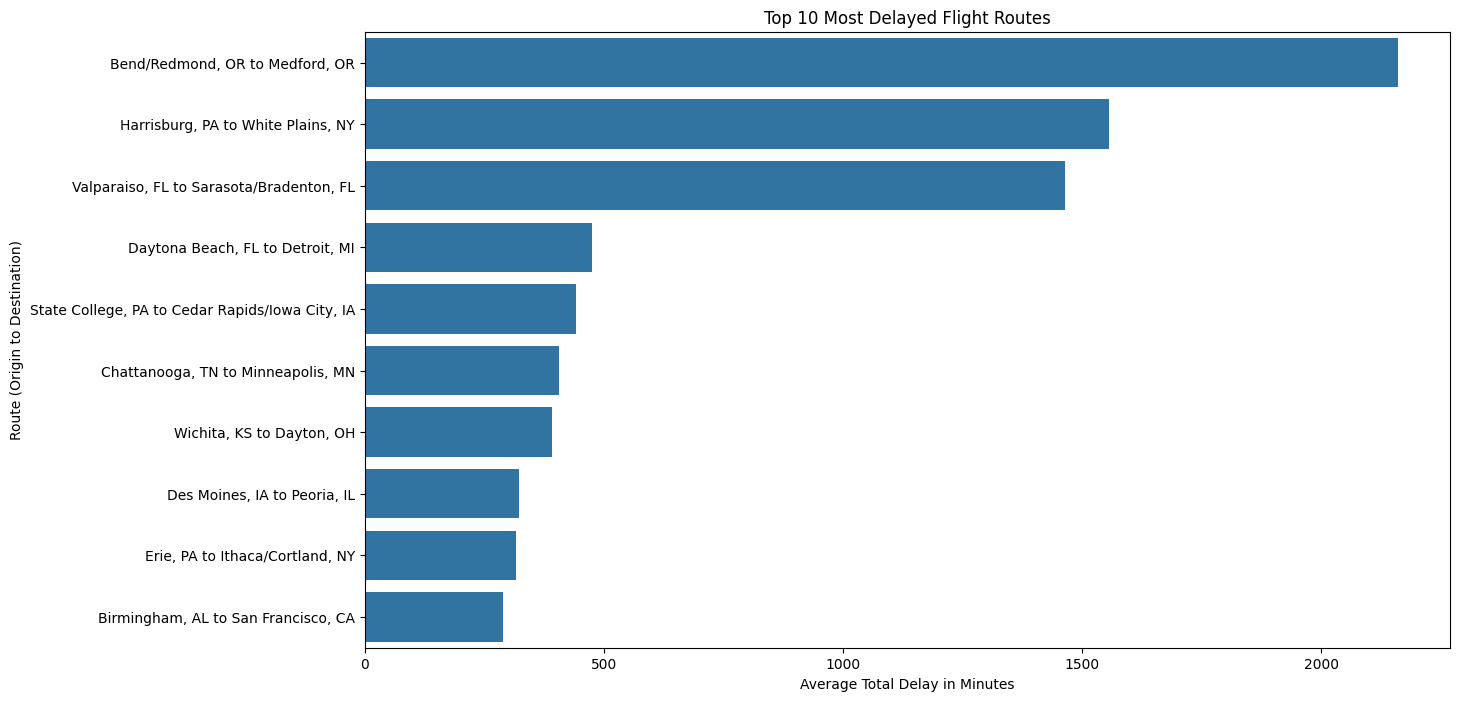

In [27]:
# plot
plt.figure(figsize=(14, 8))
sns.barplot(x='AvgTotalDelay', y='Route', data=route_delays_pd)
plt.title('Top 10 Most Delayed Flight Routes')
plt.xlabel('Average Total Delay in Minutes')
plt.ylabel('Route (Origin to Destination)')
plt.xticks(rotation=0)
plt.show()

#### Discussion
This bar plot shows the top 10 most delayed flight routes ranked by the average total delay, which is the combined sum of both departure and arrival delays. The x-axis represents the total average delay in minutes, while the y-axis displays the origin and destination cities. We note that the route with the most significant delay, Bend/Redmond, OR to Medford, OR, occurs within the same state, with an average total delay of around 2200 minutes or 36 hours which is significantly higher than the other routes. Additionally, most of the other delayed flights seem to occur when the flights are approximately halfway across the country. Further analysis could explore how the amount of delayed flights on each route correlates with the average total delay.

### Which airlines experience the most delays?

In [28]:
# combining departure delay and arrival delay to one column
df2 = df2.withColumn('TotalDelay', F.col('DepDelayMinutes') + F.col('ArrDelayMinutes'))

In [ ]:
# renaming airline codes to their respective names
airline_mapping = {
    'AX': 'Trans States Airlines',
    'C5': 'Commutair/Champlain Enterprises Inc.',
    'G7': 'GoJet Airlines/United Express',
    'ZW': 'Air Wisconsin Airlines Corp',
    'EV': 'ExpressJet Airlines inc.',
    'B6': 'JetBlue Airways',
    'YV': 'Mesa Airlines Inc.',
    'OO': 'Skywest Airlines Inc',
    'F9': 'Frontier Airlines Inc',
    'G4': 'Allegiant Air'
}

In [29]:
# selecting only delays that are over 0
delayed_flights = df2.filter(df2['TotalDelay'] > 0)

In [30]:
# delayed_flights.printSchema()

In [31]:
# group by airline, then calculating the total average delay
total_delay = delayed_flights.groupBy("Operating_Airline").agg(
    F.avg("TotalDelay").alias("TotalDelayMinutes")
).orderBy(F.col("TotalDelayMinutes").desc())

In [32]:
# convert to pandas
total_delay_pd = total_delay.limit(10).toPandas()

In [ ]:
total_delay_pd['Operating_Airline_Name'] = total_delay_pd['Operating_Airline'].map(airline_mapping)

In [33]:
total_delay_pd.head(10)

,Operating_Airline,TotalDelayMinutes
0,AX,103.076167
1,C5,102.496551
2,G7,94.423435
3,ZW,91.184112
4,EV,90.304443
5,B6,82.738956
6,YV,81.838284
7,OO,78.631575
8,F9,76.504412
9,G4,76.198356


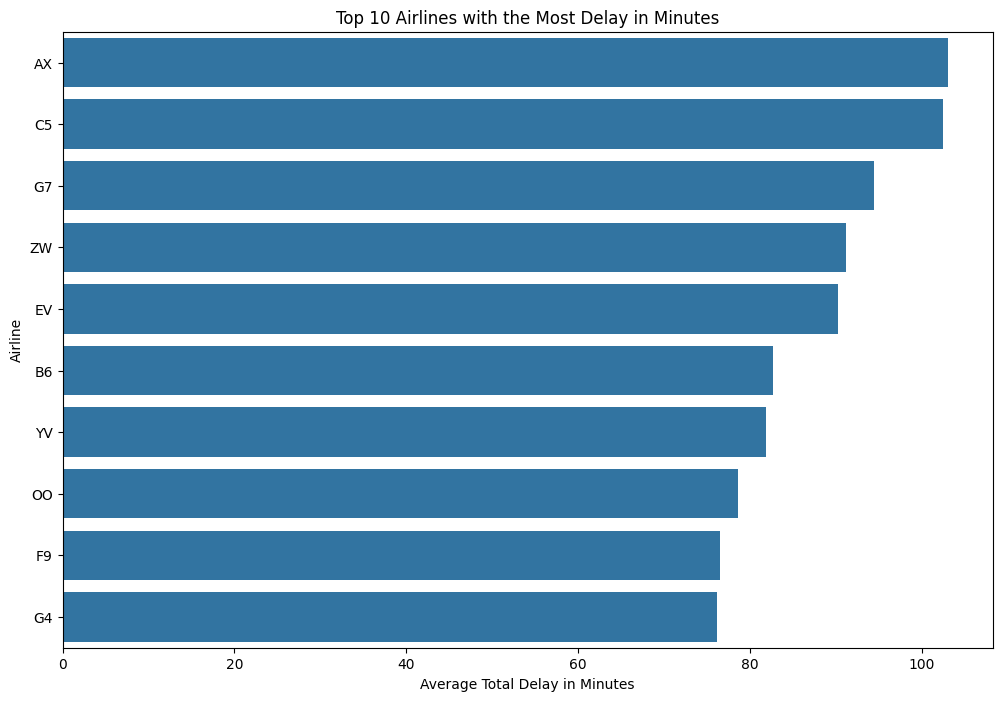

In [34]:
# plot
plt.figure(figsize=(12, 8))
sns.barplot(x="TotalDelayMinutes", y="Operating_Airline", data=total_delay_pd)
plt.title('Top 10 Airlines with the Most Delay in Minutes')
plt.xlabel('Average Total Delay in Minutes')
plt.ylabel('Airline')
plt.show()

#### Discussion
This bar plot illustrates the top 10 airlines with the highest average total delay, measured in minutes. The x-axis represents the total average delay, while the y-axis lists the airlines. It’s clear from the plot that certain airlines, such as Trans States Airlines and Commutair, experience somewhat higher delays than others with their total delays averaging over 100 minutes or a little over 1.5 hours. Further analysis could focus on the specific factors contributing to delays within these airlines, such as location, weather, or operational challenges. 

### Do flights with a longer distance have longer departure delays?

In [39]:
# convert to pandas
distance_delays_sample_pd = df2.select("Distance", "DepDelayMinutes").sample(withReplacement=False, fraction=0.3, seed=42).toPandas()


In [40]:
# convert to numeric to prevent error
distance_delays_sample_pd['Distance'] = pd.to_numeric(distance_delays_sample_pd['Distance'], errors='coerce')
distance_delays_sample_pd['DepDelayMinutes'] = pd.to_numeric(distance_delays_sample_pd['DepDelayMinutes'], errors='coerce')

In [41]:
# removing any NaNs and 0 values
distance_delays_sample_pd = distance_delays_sample_pd.dropna(subset=['Distance', 'DepDelayMinutes'])
distance_delays_sample_pd = distance_delays_sample_pd[(distance_delays_sample_pd['Distance'] > 0) & (distance_delays_sample_pd['DepDelayMinutes'] > 0)]

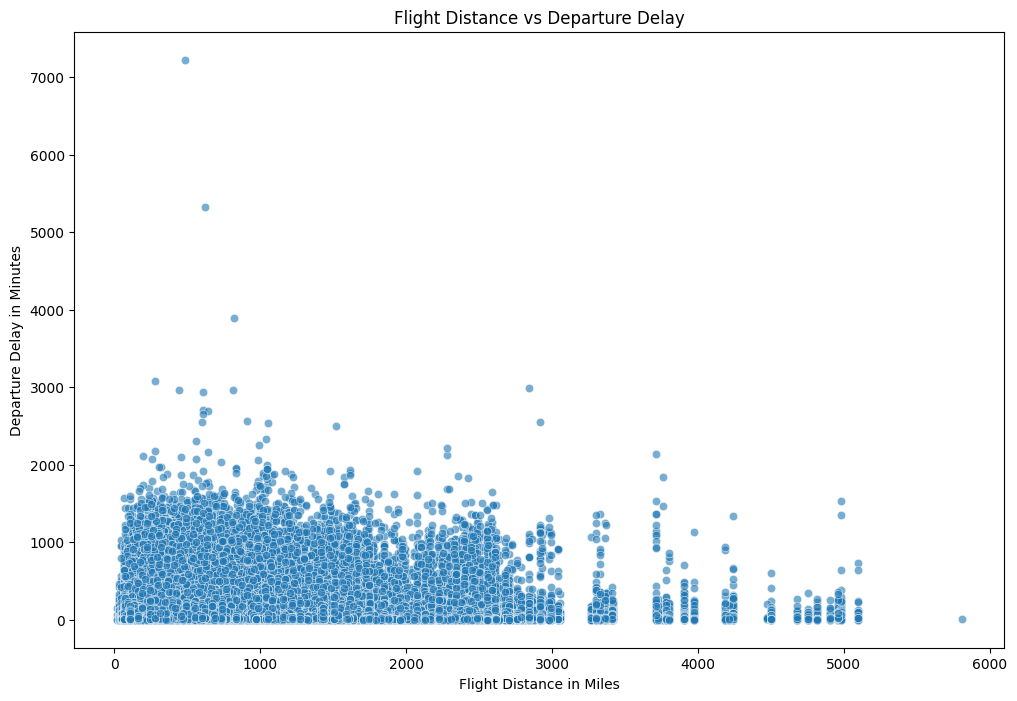

In [42]:
# plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Distance', y='DepDelayMinutes', data= distance_delays_sample_pd, alpha=0.6)
plt.title('Flight Distance vs Departure Delay')
plt.xlabel('Flight Distance in Miles')
plt.ylabel('Departure Delay in Minutes')
plt.show()

#### Discussion
This scatter plot compares flight distance and departure delay, with flight distance being on the x-axis and departure delay on the y-axis. It is only a sample of the whole dataset, and shows that there’s no clear correlation between the distance and delay. However, we can somewhat see that there is a slightly negative correlation where shorter flights have longer delays and longer flights have shorter delays. Further analysis could explore how specific factors contribute to delays, especially for shorter flights.

### Checking delayed and cancelled flights Group By by operating airlines and time

The following columns were manually chosen after reading column description on Kaggle.

In [43]:
cols_to_check = ['Marketing_Airline_Network', 'Operating_Airline', 'Origin', 'Dest', 'DepDel15', 'DepDelay', 'ArrDel15', 'ArrDelay',\
                 'Cancelled', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',\
                 'Distance', 'Year', 'Month', 'DayofMonth', 'FlightDate', 'Flight_Number_Operating_Airline']
print(f'col_to_check = {len(cols_to_check)}')
# Check to see if interested columns is in columns_with_few_nulls
removed_col = []
my_cols = []
for c in cols_to_check:
    if c in filtered_df.columns:
        my_cols.append(c)
    else:
        removed_col.append(c)

print('Chosen columns:')
print(my_cols)
print()
print('Rejected columns:')
print(removed_col)

col_to_check = 20
Chosen columns:
['Marketing_Airline_Network', 'Operating_Airline', 'Origin', 'Dest', 'DepDel15', 'DepDelay', 'ArrDel15', 'ArrDelay', 'Cancelled', 'Distance', 'Year', 'Month', 'DayofMonth', 'FlightDate', 'Flight_Number_Operating_Airline']

Rejected columns:
['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


In [44]:
# Filter out a subset of columns to do data analysis
Nam_df = filtered_df.select(my_cols)

Cancelled flights have nulls values in other columns!

In [45]:
cols_to_check = ['DepDel15', 'DepDelay', 'ArrDel15', 'ArrDelay']
print('There are entries where Cancelled column will have value of 1 (canceled) while other columns might be null')
for c in cols_to_check:
    num_to_display = Nam_df.where(isnull(col(c)) & (col('Cancelled') == 1)).count()
    print(f'Number of entries where {c} column is null but Cancelled is 1: {num_to_display}')

There are entries where Cancelled column will have value of 1 (canceled) while other columns might be null
Number of entries where DepDel15 column is null but Cancelled is 1: 761971
Number of entries where DepDelay column is null but Cancelled is 1: 761971
Number of entries where ArrDel15 column is null but Cancelled is 1: 777267
Number of entries where ArrDelay column is null but Cancelled is 1: 777267


Since I intend to do data exploration with cancelled flights, it is not a good idea for me to do dropna() on the dataset as I will lose data for those flights.

In [46]:
# check number of flights that are delayed by more 15 minutes and cancelled flights
num_delayed = Nam_df.where(col('DepDel15') == 1).count()
num_cancelled = Nam_df.where(col('Cancelled') == 1).count()
print(f'Number of flights that were delayed by more than 15 minutes: {num_delayed}')
print(f'Number of flights that were cancelled: {num_cancelled}')

Number of flights that were delayed by more than 15 minutes: 4911896
Number of flights that were cancelled: 777267


#### Group by operating airline data analysis

In [47]:
# aggregate by operating airline and turn into Pandas dataframe
airline_flights = Nam_df.groupBy(col('Operating_Airline')).agg(F.sum(col('DepDel15')).alias('DelayedFlights'),
                                                               F.sum(col('Cancelled')).alias('CancelledFlights'),
                                                               F.count('*').alias('TotalFlights'))
airline_flights_pd = airline_flights.toPandas()
airline_flights_pd['DelayedPercentage'] = airline_flights_pd['DelayedFlights'] / airline_flights_pd['TotalFlights']
airline_flights_pd['CancelledPercentage'] = airline_flights_pd['CancelledFlights'] / airline_flights_pd['TotalFlights']
airline_flights_pd.head(5)

,Operating_Airline,DelayedFlights,CancelledFlights,TotalFlights,DelayedPercentage,CancelledPercentage
0,UA,401781.0,47061.0,2354538,0.170641,0.019987
1,NK,150479.0,18150.0,836694,0.179850,0.021693
2,AA,544419.0,95058.0,3134117,0.173707,0.030330
3,EV,62030.0,14363.0,353669,0.175390,0.040611
4,B6,275829.0,29095.0,1106079,0.249375,0.026305


Text(0, 0.5, '')

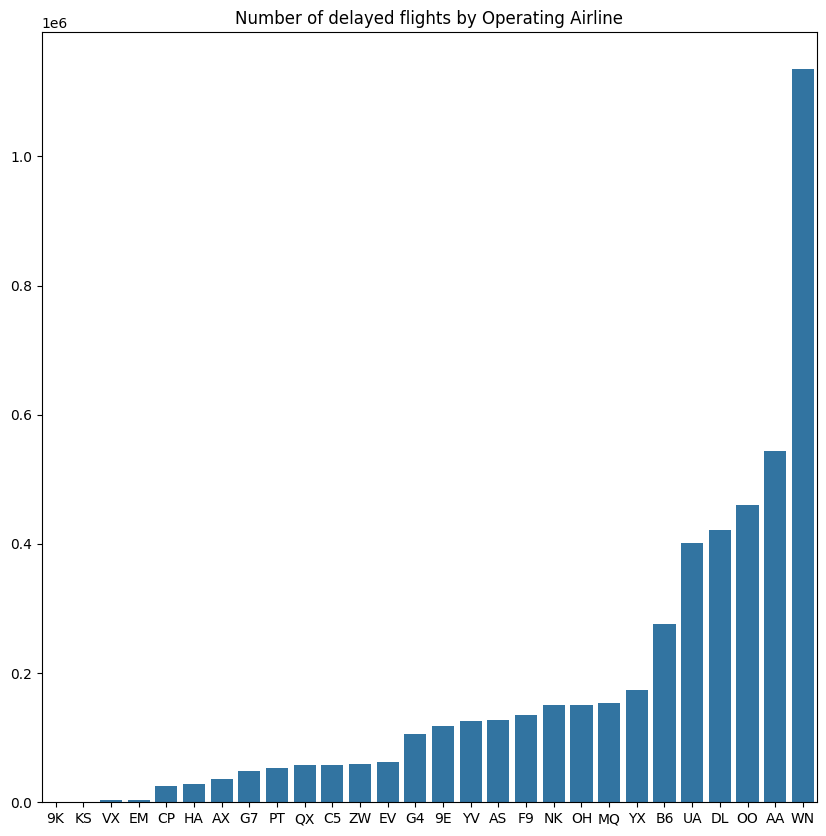

In [48]:
# Graph number of delayed flights by airlines
airline_flights_pd = airline_flights_pd.sort_values(by = 'DelayedFlights', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
percentage_barplot = sns.barplot(data = airline_flights_pd, x = 'Operating_Airline', y = 'DelayedFlights')
plt.title('Number of delayed flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

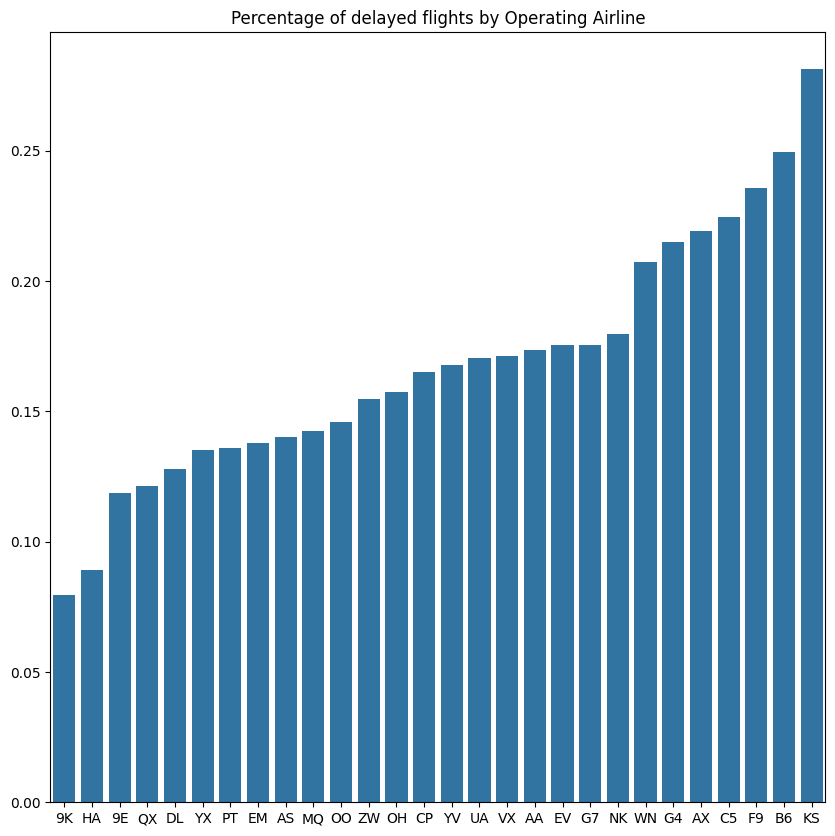

In [49]:
# Graph delay flight percentage by airline
airline_flights_pd = airline_flights_pd.sort_values(by = 'DelayedPercentage', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
percentage_barplot = sns.barplot(data = airline_flights_pd, x = 'Operating_Airline', y = 'DelayedPercentage')
plt.title('Percentage of delayed flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

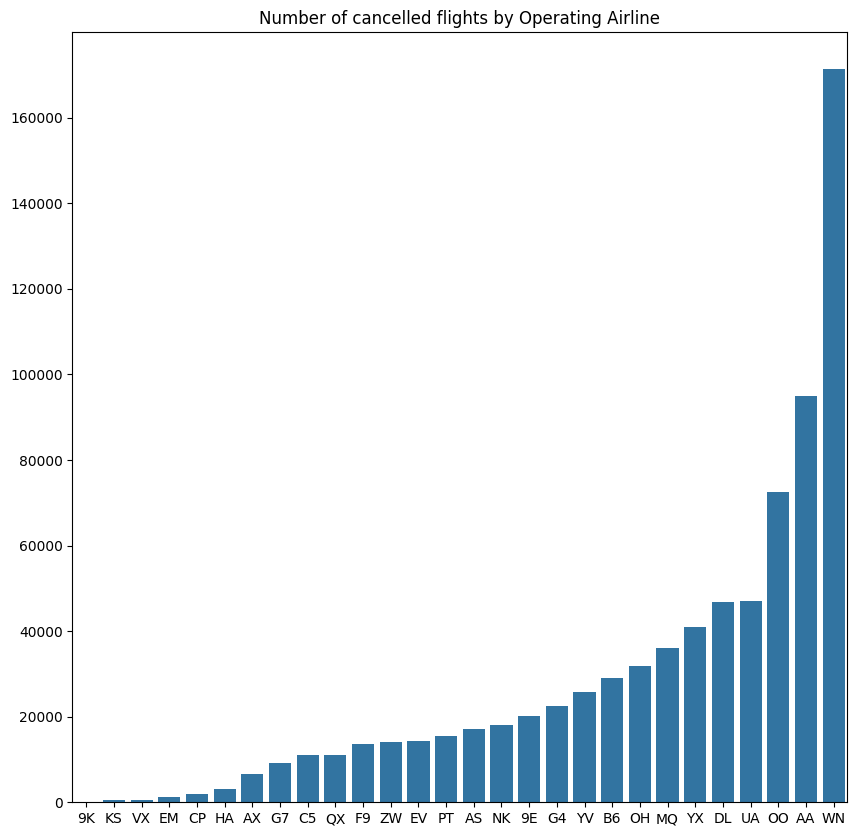

In [50]:
# Graph number of cancelled flights by airlines
airline_flights_pd = airline_flights_pd.sort_values(by = 'CancelledFlights', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data = airline_flights_pd, x = 'Operating_Airline', y = 'CancelledFlights')
plt.title('Number of cancelled flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

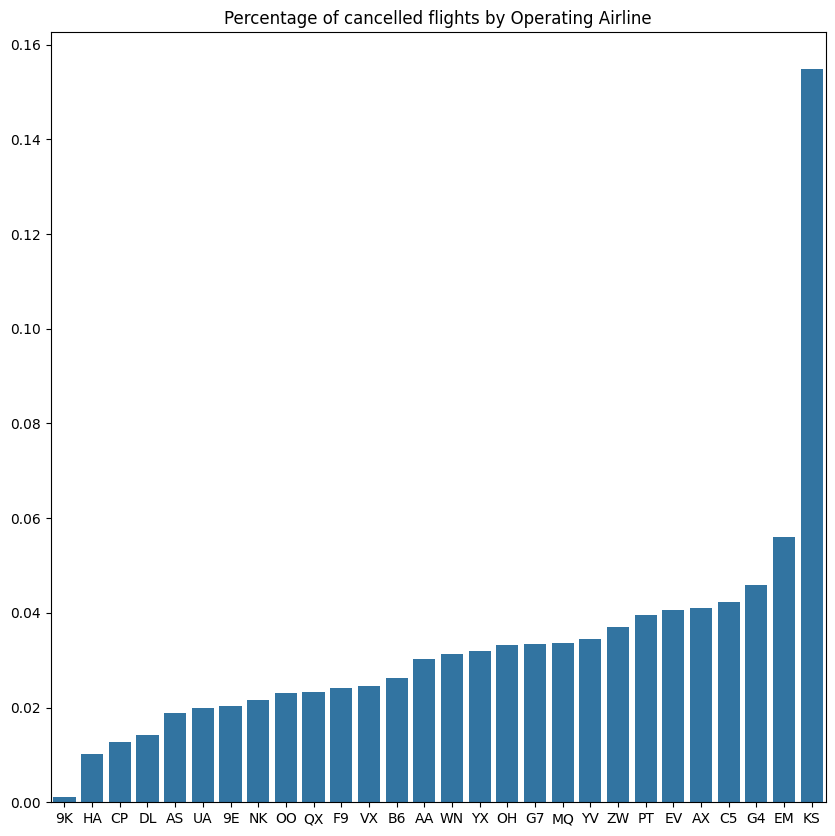

In [51]:
# Graph peracentage of cancelled flights by airlines
airline_flights_pd = airline_flights_pd.sort_values(by = 'CancelledPercentage', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data = airline_flights_pd, x = 'Operating_Airline', y = 'CancelledPercentage')
plt.title('Percentage of cancelled flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

#### Group by time data analysis

In [52]:
# Group by Year and Month and turn into Pandas df
time_agg = Nam_df.groupBy('Year', 'Month').agg(F.sum(col('DepDel15')).alias('DelayedFlights'),
                                              F.sum(col('Cancelled')).alias('CancelledFlights'),
                                              F.count('*').alias('TotalFlights'))
time_agg_pd = time_agg.toPandas()
time_agg_pd['DelayedPercentage'] = time_agg_pd['DelayedFlights'] / time_agg_pd['TotalFlights']
time_agg_pd['CancelledPercentage'] = time_agg_pd['CancelledFlights'] / time_agg_pd['TotalFlights']
time_agg_pd.head(5)

,Year,Month,DelayedFlights,CancelledFlights,TotalFlights,DelayedPercentage,CancelledPercentage
0,2021,8,136450.0,18734.0,611494,0.223142,0.030636
1,2018,1,80577.0,12690.0,457688,0.176052,0.027726
2,2022,3,123957.0,9108.0,590542,0.209904,0.015423
3,2021,12,128550.0,13773.0,580238,0.221547,0.023737
4,2021,7,152566.0,10195.0,615703,0.247792,0.016558


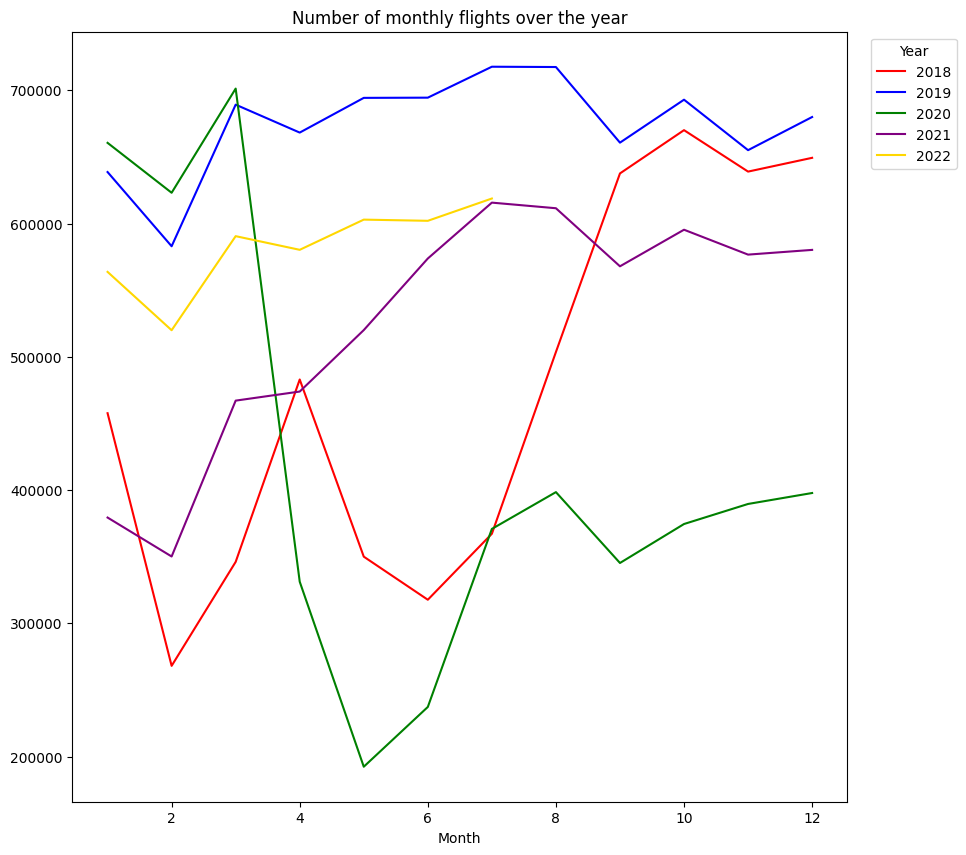

In [53]:
# Graph number of flights overtime
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'TotalFlights', hue = 'Year', palette = colors)
plt.title('Number of monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

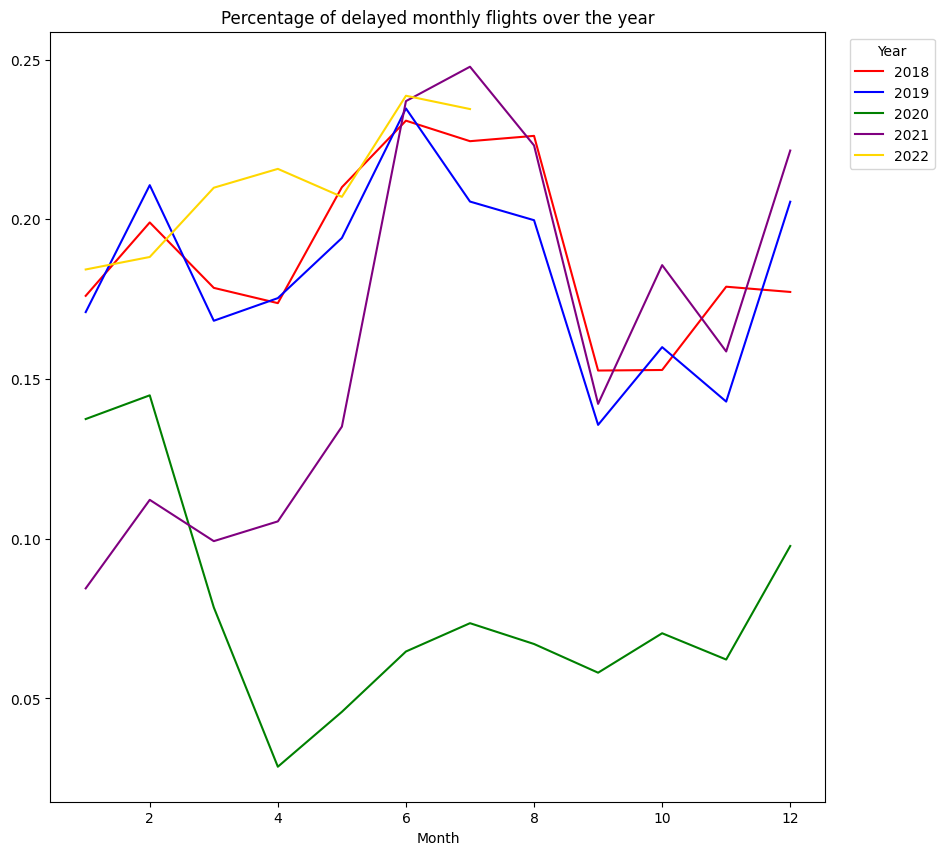

In [54]:
# Graph percentage of delayed flights over time
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'DelayedPercentage', hue = 'Year', palette = colors)
plt.title('Percentage of delayed monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

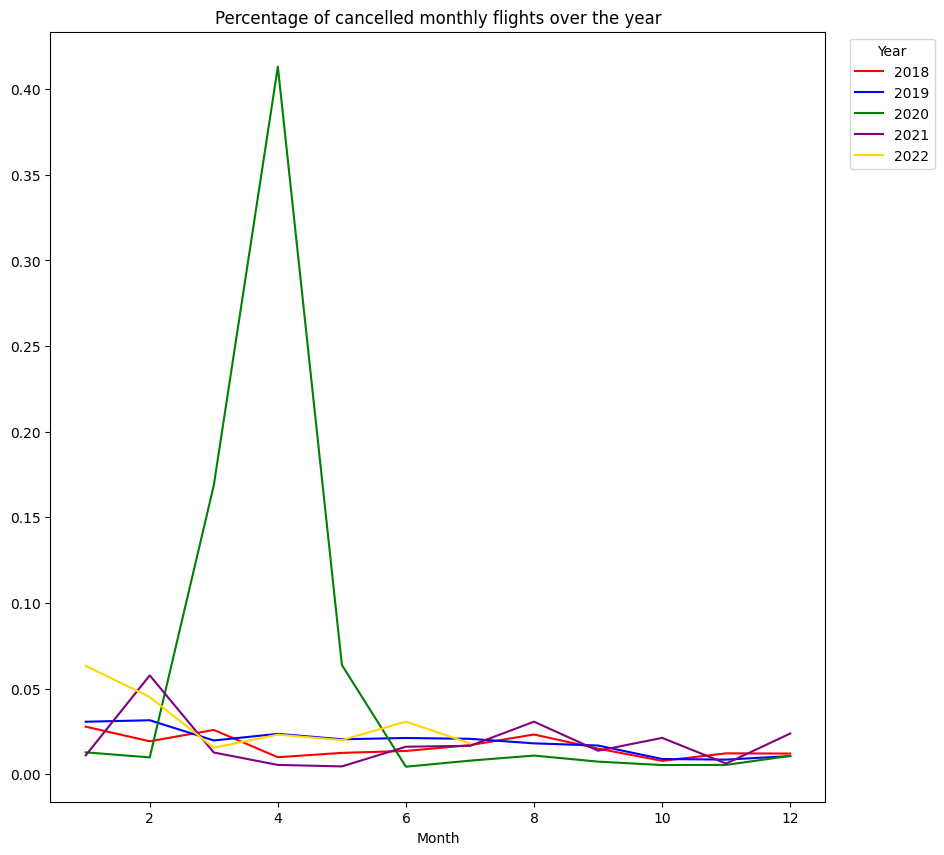

In [55]:
# Graph percentage of cancelled flights over time
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'CancelledPercentage', hue = 'Year', palette = colors)
plt.title('Percentage of cancelled monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

#### Discussion

**<u>Data cleaning</u>**

Thanks to the team's work, we can learn that the majority of columns in our dataset contains a large number of NaN. We are able to quickly filter out those columns and focus on the others.
My analysis focused on delayed and cancelled flights. I learned that entries of cancelled flights will have nulls in other columns making a simple dropna() not a viable data cleaning method.
If we are to work with cancelled flights, we have to find away to fill in the nulls of other columns.

**<u>Aggregated by operating airlines</u>**

Despite how miserable air travelling is, flights are seldomly late. About 10 - 25% of flights are at least 15 minutes late to depart. From the graph, I would say that an average of about 15% of flights operated by any airlines are late to depart.

Airlines are keen to keep their flights operational cancelling less than 5% of their total scheduled flights. This makes sense as cancellation results in not only loss of revenue but also compensation of damages and potential loss of opportunities.

Airline denoted by KS (Peninsula Airways) stood out to me. They do not serve a lot of flights. But their delayed and cancelled metrics are area of improvement to say the least.

**<u>Aggregated by time</u>**

Acknowledgement: I understand that the airline industry was heavy affected by COVID-19 and that the industry is recovering to pre-pandemic numbers.

Overall, it seems that February tends to be a slow month for the airline industry. The summer months are busy. The holiday months of September - December are only slight less busy than the summer months. People are more likely to travel in the second half of the year.

The data for 2018 flights stood out to me. The year started with fewer flights than 2021 and 2022 (post COVID-19 years) but then suddenly gained 300,000 flights for the summer months. This indicates to me that there is a potential socio/economical/geopolitical event happening and/or issue with data collection.

Delayed flights are likely to happen during peak of the traveling seasons contributing to the misery of air travelling. February is an interesting month as customers are not travelling but flights pick up an increase in chance of being delayed. My guess is that flight crews and ground crews are burned out from the holiday season and their performance is decreased.

As for cancelled flights, there is a gigantic mountain that sits in the middle of the graph. Almost half of scheduled flights for April of 2020 are cancelled. I wonder what happened.